In [295]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza

from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm

## Reviews download
https://pypi.org/project/steamreviews/

In [296]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [297]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [298]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [299]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [300]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
31519,Baba Is You,P,76561198083027212,55,Baba is recommend\nis \nhard,0.831581294536590576,True,0,5077,9,1656682805
107,Omori,R,76561198372460713,37,"When I first played the game, I got to the [sp...",0.737550437450408936,True,0,3114,8,1671995841
2404,Sea of Thieves,A,76561198453348654,12,lemme cook megalodon,0.615646541118621826,True,0,882,5,1683376506
19942,Factorio,S,76561198215767700,2,Ethan hates this game,0.523809552192687988,True,0,2747,40,1684013844
10997,Sid Meier's Civilization VI,S,76561198074980349,1,"Cool game, diverse achievements if you're into...",0.52173912525177002,True,0,29349,1,1692931580


In [301]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [302]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [303]:
df.duplicated(subset='review').sum()

2580

In [304]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
27769,Portal 2,P,76561198372502063,1,Masterpiece,0.50323253870010376,True,0,628,8,2023-07-21 21:41:13
23486,Left 4 Dead 2,A,76561198178970699,1,<3,0.523809552192687988,True,0,1764,1,2023-03-09 02:59:30
13331,RimWorld,S,76561198156349640,1,its pretty good,0.523809552192687988,True,99,52771,2,2022-11-23 01:48:17
882,Omori,R,76561198286535147,1,Masterpiece,0.523809552192687988,True,291,1009,6,2023-04-23 09:32:47
26615,Portal 2,P,76561198828509095,1,good game,0.523809552192687988,True,53,508,9,2023-03-24 20:27:25
7036,The Past Within,P,76561198244956954,3,fun,0.554186105728149414,True,672,209,154,2024-02-10 22:43:44
10547,Sid Meier's Civilization VI,S,76561198280372489,1,i love it,0.523809552192687988,True,0,10122,1,2023-02-28 21:20:23
15942,Hearts of Iron IV,S,76561198087703543,1,sex,0.523809552192687988,True,208,10912,70,2023-04-20 03:13:19
3612,Sea of Thieves,A,76561199187593040,1,good,0.523809552192687988,True,0,6726,1,2023-05-05 13:04:17
1082,Omori,R,76561199213325441,1,good,0.523809552192687988,True,0,180,1,2023-02-04 07:48:27


In [305]:
(df.duplicated(subset='review') == False).sum()

29492

In [306]:
df = df[df.duplicated(subset='review') == False]

In [307]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [308]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [309]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [310]:
df = df[df["temp_review_len"] >= 3]

In [311]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [312]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [313]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

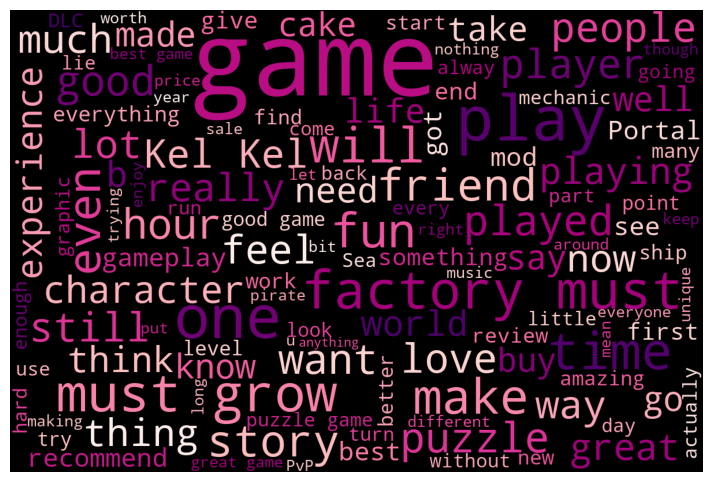

In [314]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

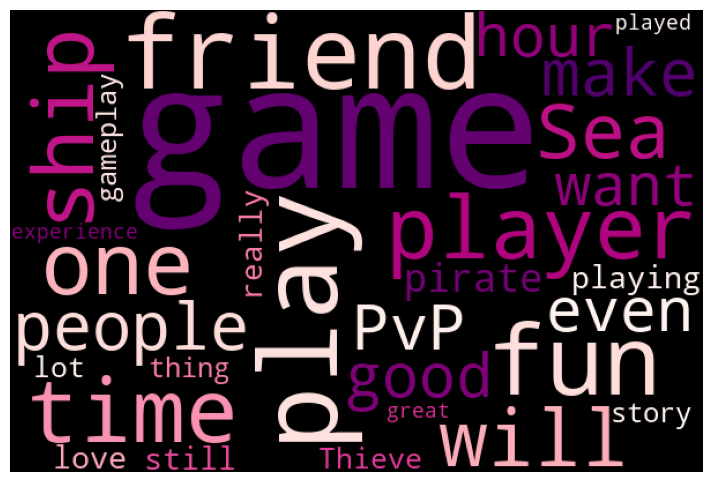

In [315]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

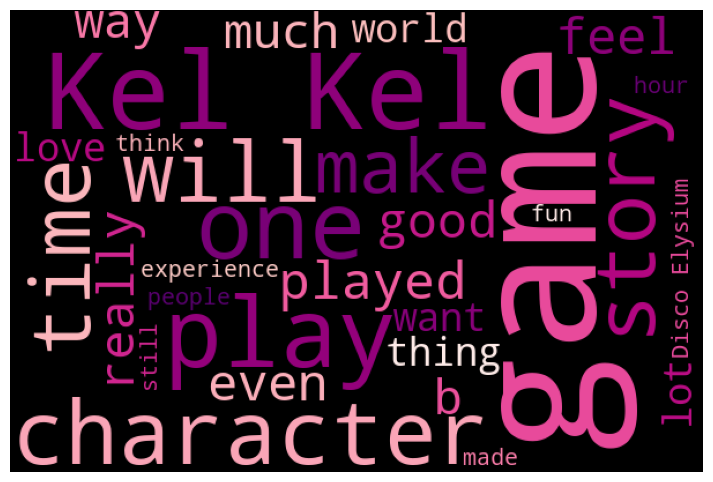

In [316]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

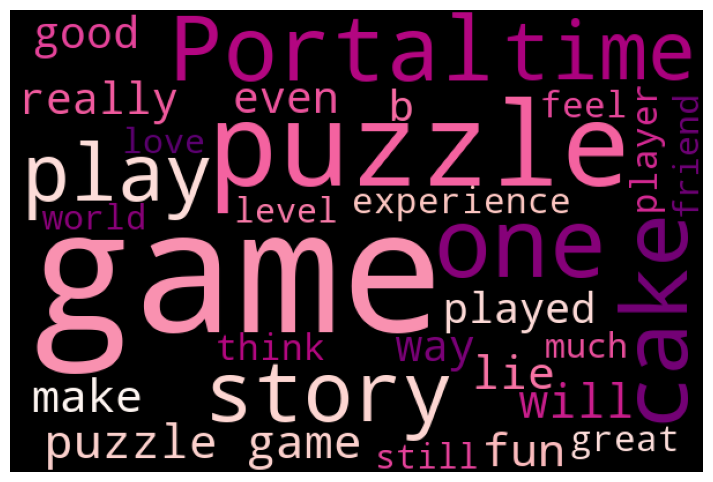

In [317]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

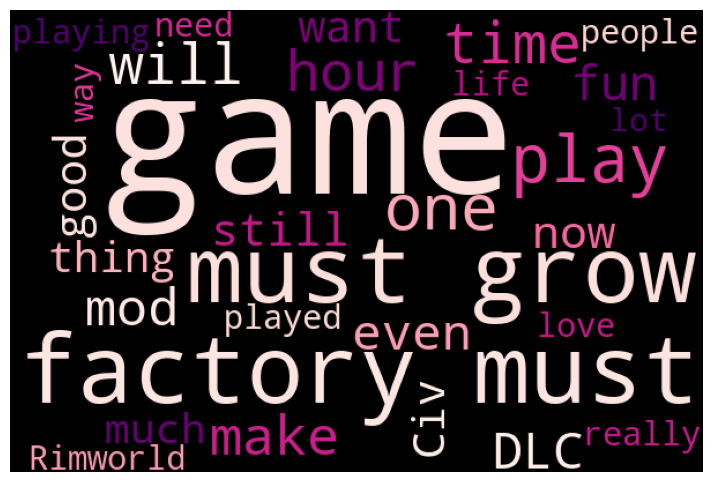

In [318]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [319]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [320]:
df["review"].sample(10)

8741     a masterclass of puzzle design, which, althoug...
17905    i remember this game being way longer, but i g...
17121    the peace conferences are insane nonsense ,  b...
16667    you should definitely try this out! maybe it w...
2492      all on the waves shall know our story  sing o...
207      i love omori i love omori i love omori i love ...
10546    i've played a lot of civiilization games, but ...
20096      like crack but legal and arguably worse for you
11380                                                 ! :.
26445    whetlery is britierijsj. cube. lemoen    yesl,...
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [321]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [322]:
import string 
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [323]:
df["review"].sample(5)

13731    war crimes and cannibalism that is all i have ...
382      omori is such a wholesome experience which ill...
28334    if you like this game  sail the high seas do n...
27900    dont have much experience in this game but wha...
26631    before you buy the story of portal  is based o...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [324]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [325]:
import nltk
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [326]:
df["tokenized"].sample(15)

2976     [whoever, designed, the, hourglass, deserves, ...
12077    [i, was, considering, buying, this, game, for,...
27548    [what, exactly, is, wrong, with, being, adopte...
11240    [great, game, but, the, crappy, launcher, kill...
1463     [the, ending, fr, made, me, cry, easily, one, ...
12024    [not, what, i, hoped, for, purchased, when, ho...
6748     [play, with, your, friendits, a, lot, of, fun,...
9744     [i, feel, like, i, have, to, post, a, new, rev...
9884     [a, week, ago, i, was, diagnosed, with, a, ter...
4029     [wont, let, me, play, the, game, just, says, p...
9627                 [its, like, controllin, a, dd, party]
3303     [i, havent, had, this, much, fun, pouring, thi...
26994    [best, game, ever, i, have, played, it, a, lon...
29312    [you, cant, compare, this, game, to, anything,...
6785     [a, great, way, to, kill, an, afternoon, with,...
Name: tokenized, dtype: object

### Stopwords

In [327]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [328]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [329]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [330]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [331]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [332]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_7956\2159658958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


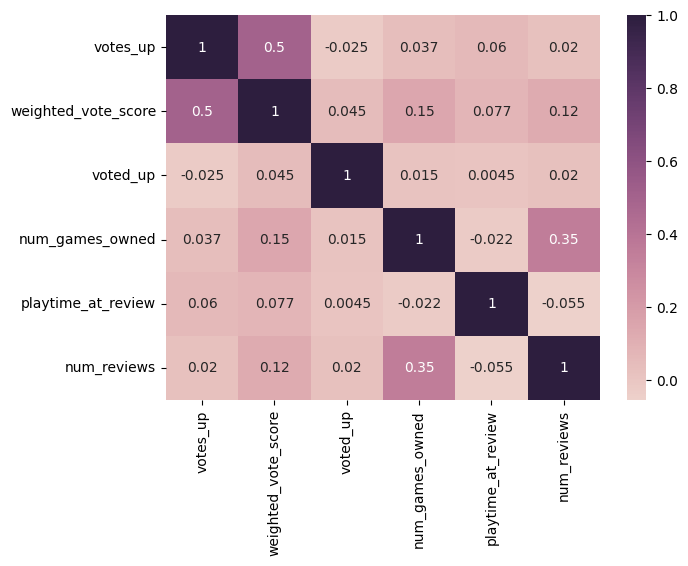

In [333]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

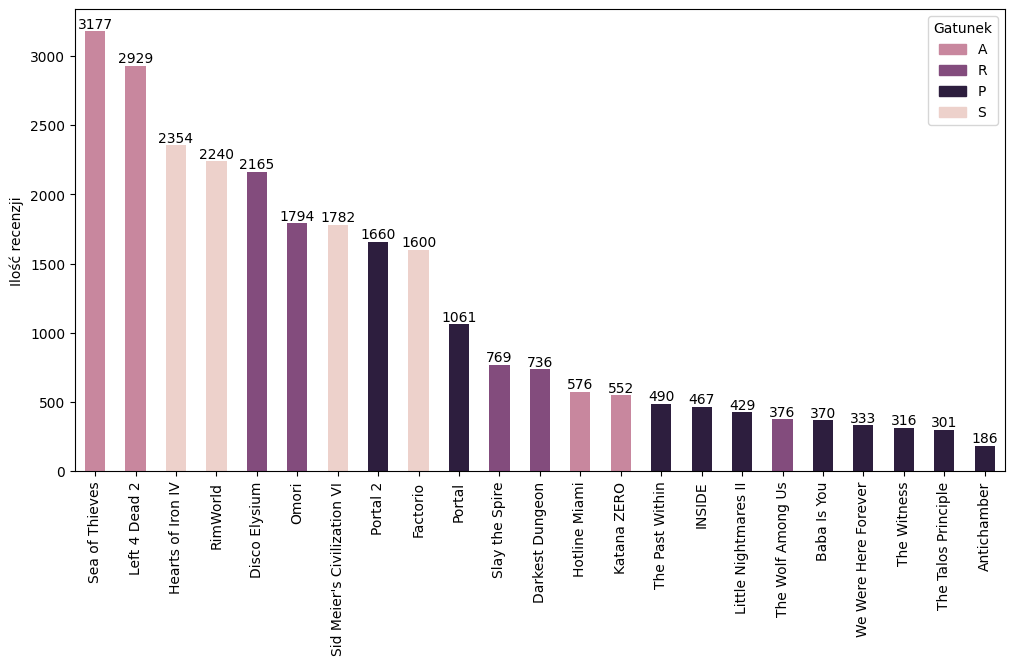

In [334]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

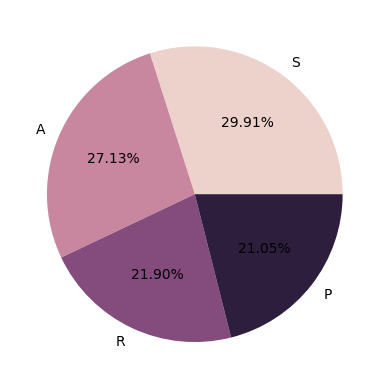

In [335]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

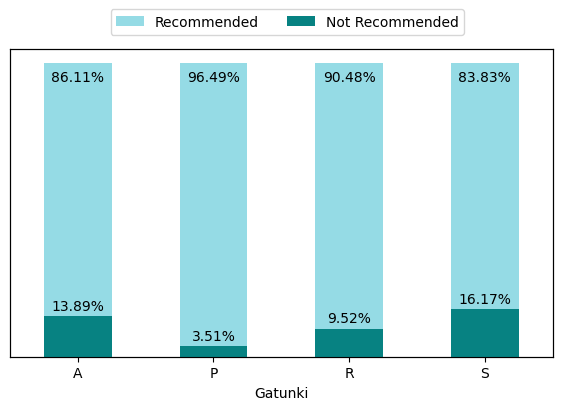

In [336]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [337]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [338]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-04-20 21:12:57 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-20 21:12:58 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-04-20 21:13:01 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-04-20 21:13:01 INFO: Using device: cuda
2024-04-20 21:13:01 INFO: Loading: tokenize
2024-04-20 21:13:01 INFO: Loading: mwt
2024-04-20 21:13:05 INFO: Loading: pos
2024-04-20 21:13:06 INFO: Loading: lemma
2024-04-20 21:13:06 INFO: Loading: constituency
2024-04-20 21:13:07 INFO: Loading: depparse
2024-04-20 21:13:07 INFO: Loading: sentiment
2024-04-20 21:13:07 INFO: Loading: ne

In [339]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [340]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [341]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [342]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [343]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

## Word embedding

## Correct misspeld words

In [344]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

## Similarity

### Word counts

In [346]:
unique_words = list(set(words))

In [347]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

In [391]:
popular_words = word_counts[word_counts['count']>=20]["word"].to_list()

In [392]:
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]

In [393]:
word_vectors = pd.DataFrame([i.vector for i in tokens])
word_vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-4.92790,4.94210,3.62710,-1.73430,0.933550,8.369500,0.644960,7.84830,-7.9163,0.32979,...,4.09550,-5.73040,1.909400,9.78890,-4.157100,-0.51679,0.90819,-1.71980,-3.560000,-1.78600
1,3.07460,2.39170,0.69005,-2.75750,-0.571410,0.837610,-0.376230,2.92550,-3.2766,1.10100,...,1.35710,-3.81660,4.457100,1.97130,1.975500,1.42390,0.33690,0.59065,-0.775660,-1.89730
2,1.53920,-0.39443,-1.81880,-0.96940,1.132900,-1.244400,2.506800,5.59740,-3.2240,0.54896,...,1.55660,-1.43870,-2.941000,0.93326,0.043452,-2.38520,2.93200,-1.40930,-3.590500,2.14170
3,-0.18531,2.22820,1.09940,-1.03500,-1.057100,1.820500,-0.003583,4.42410,-4.6627,0.29725,...,2.77960,-1.40250,2.953600,4.02400,-0.694170,0.88864,0.24858,-1.57040,-5.608200,-0.97147
4,-1.07540,4.73980,0.91211,-3.92970,-0.056025,10.425000,-1.671300,5.16440,-5.2849,-1.48300,...,5.97130,-3.76920,0.009614,6.09150,-0.431410,-5.20450,3.50040,3.65770,-1.781300,0.83246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,-4.16760,-1.77290,-4.46490,-1.34910,-1.314000,0.006815,1.256300,2.08650,-2.9316,1.37300,...,-1.17630,1.79670,-0.794210,-0.93913,-1.273600,-0.79217,-2.77730,-1.27930,-1.622300,-1.61580
304,-3.90650,-3.02280,-3.46070,2.09440,4.724900,0.812770,0.917290,3.26150,-1.4108,0.22974,...,-1.16900,0.51398,-0.810680,1.11260,0.019847,5.46220,-0.30220,-6.52940,-0.025955,0.22936
305,2.29530,4.02280,-2.74960,-0.77861,0.111760,0.501750,-0.354410,4.88620,-1.2744,0.24927,...,-0.32574,-2.91330,1.750100,0.62937,2.977300,-1.35680,-6.16270,2.22770,-0.544750,0.32246
306,2.97740,6.55650,2.90000,1.04460,-0.004087,2.920800,-2.953100,-0.29437,-5.3821,1.86840,...,1.24150,2.57330,1.284700,-3.71170,-1.709500,5.50770,1.55330,0.72893,-3.274000,-2.80760


## K-means

In [410]:
kmeans = KMeans(n_clusters=40, init='k-means++', random_state=324)

kmeans.fit(word_vectors)
pred = kmeans.predict(word_vectors)

clustered_words = pd.DataFrame([[str(i) for i in tokens], pred], index=['word', 'cluster']).T

for ind, cl in clustered_words.groupby('cluster'):
    print(f'=====================================\nCluster no:{ind}')
    print(*cl['word'], sep='\n')

C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster no:0
entry
Cluster no:1
character
graphic
visual
genre
horror
plot
episode
book
narrative
humor
classic
chapter
pve
novel
Cluster no:2
price
grind
update
NASA
run
pack
purchase
builder
crash
ride
route
bonus
build
upgrade
buying
Cluster no:3
colony
building
colonist
civilization
city
force
empire
country
power
group
faction
nation
Cluster no:4
guy
kid
boy
child
woman
girl
Cluster no:5
look
wait
pass
call
find
leave
Cluster no:6
review
word
example
note
usage
case
list
error
ld
Cluster no:7
need
wish
hope
help
want
can
Cluster no:8
go
Cluster no:9
pirate
boss
luck
zomby
guess
zombie
pawn
wolf
coop
hell
rng
fuck
nightmare
vibe
joke
gamei
ruin
cry
Cluster no:10
world
robot
planet
universe
Cluster no:11
hero
fan
name
god
lore
legend
gem
Cluster no:12
civ
pvp
Cluster no:13
bug
glitch
Cluster no:14
lot
bit
Cluster no:15
fight
battle
combat
war
Cluster no:16
friend
lake
piece
hand
voice
couple
night
figure
heart
face
color
brain
front
pixel
cutscene
half
paint
finish
limbo
cosmetic
li

In [267]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt